In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import numpy as np

def get_stock_data(symbol,duration):
    def mkdays(val):
        return val.days
    def mkdaystr(val):
        return val.strftime('%Y.%m.%d')
    df = yf.Ticker(symbol).history(duration)
    df['Company'] = symbol
    df['Date'] = df.index
    df.reset_index(drop=True, inplace=True)
    vals = df.Date - df.Date[0] 
    df['Days'] = list( map( mkdays, vals ) )
    df['Daystring'] = list( map( mkdaystr, df.Date ) )
    # df = df[['Date','Company','Close','Volume']]
    return df

def thinticks(df, showeach):
    val = df.Days
    lab = df.Date
    vals = []
    labs = []
    k = 0
    while k < len(val):
        vals.append( val[k] )
        labs.append( lab[k].strftime('%Y.%m.%d') )
        k = k + showeach
    return vals, labs
    
def standard_plot(df, showeach, title_string, window):
    def findwindowave(values, window):
        mx = len(values)
        windowave = []
        for k in range(0,mx):
            left = right = k
            if k > window:
                left = k - window
            if (k+window) < mx:
                right = k + window
            windowave.append( np.average( values[left:right] ) )
        return windowave
    
    plt.figure(figsize=(9,3))
        
    x, y = df.Days, df.Close
    plt.scatter(x, y,  s=1, c='black')
    plt.scatter(x, findwindowave(y, window),  s=10, c='black')
    #plt.scatter(x, df.Low,  s=1, c='blue')
    vals, labs = thinticks(df, showeach)
    trap = plt.xticks(vals, labs, rotation=90)
    plt.ylabel('Close $')
    plt.xlabel('Date')
    plt.title(title_string)
    
    plt.show()
    
def findwindowave(values, window):
    mx = len(values)
    windowave = []
    for k in range(0,mx):
        left = right = k
        if k > window:
            left = k - window
        if (k+window) < mx:
            right = k + window
        windowave.append( np.average( values[left:right] ) )
    return windowave


# This creates a plot with two axis.  One in $ and the second as Fraction relative
# to the observed minimum.  
def doubleplot(df, showeach, title_string, window):
    x = df.Days
    y = df.Close
    yavg = findwindowave(y, window)
    mn = min( list(df.Close) )
    ynorm = df.Close / mn
    ynormf = findwindowave(ynorm, window)
    
    
    fig, ax1 = plt.subplots()
    fig.set_figheight(5)
    fig.set_figwidth(10)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Share Price [$]', color='black')
    ax1.plot(x, y, linestyle='None', marker='.', color='blue', markersize=5)
    ax1.plot(x, yavg, linestyle='None', marker='.', color='green', markersize=10)
    ax1.tick_params(axis='y', labelcolor='black')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    # this is an invisible series intentionally right now.  
    # the 'Fraction' axis is slightly offset from the $ axis.  
    # This will be fixed but currently the Fraction axis serves to show 
    # the percentage gain/losses compared to the minima seen on the current time 
    # window

    ax2.set_ylabel('Fraction', color='black')  # we already handled the x-label with ax1
    ax2.plot(x, ynormf, linestyle='None', marker='.', color='black', markersize=0)
    ax2.tick_params(axis='y', labelcolor='black')
    
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    vals, labs = thinticks(df, showeach)
    trap = plt.xticks(vals, labs)
    matplotlib.pyplot.sca(ax1)
    plt.xticks(rotation=90)
    plt.title(title_string)

    plt.show()
    standard_plot(df, showeach, title_string, window)


# This creates a plot with two axis.  One is value invested
def doubleplot_(df, showeach, title_string, window):
    x = df.Days
    
    fig, ax1 = plt.subplots()
    fig.set_figheight(3)
    fig.set_figwidth(9)
    
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Value Owned[$]', color='black')
    ax1.plot(x, df.value, linestyle='None', marker='.', color='blue', markersize=5)
    ax1.plot(x, df.spent, linestyle='None', marker='.', color='green', markersize=10)
    
    #fig.tight_layout()  # otherwise the right y-label is slightly clipped

    vals, labs = thinticks(df, showeach)
    trap = plt.xticks(vals, labs)
    matplotlib.pyplot.sca(ax1)
    plt.xticks(rotation=90)
    plt.title(title_string)

    plt.show()
    standard_plot(df, showeach, '', window)

    
def create_invested(invested,df):
    df.loc[( (df.Daystring>=invested[0]) ),'shares'] = \
        df.loc[( (df.Daystring>=invested[0]) ),'shares'] + invested[2]
    df.loc[( (df.Daystring>=invested[0]) ),'spent'] = \
        df.loc[( (df.Daystring>=invested[0]) ),'spent'] + invested[1]    
    return df

def add_instestments(df,investments,symbol):
    df['shares'] = 0.00 
    df['spent'] = 0.00 
    df['gain'] = 0.00 
    for invest in investments[symbol]:
        df = create_invested(invest,df)
        df['value'] = df['Close'] * df['shares']
        df.loc[( (df['shares']>0.00) ),'gain'] = \
           df.loc[( (df['shares']>0.00) ),'value']/df.loc[( (df['shares']>0.00) ),'spent']
    return df   


def portfolio_value(investments, symbol, latest_date):
    invested = investments[symbol]
    df = yf.Ticker(symbol).history('1d')
    shares = 0
    outlay = 0
    close = 0
    first_investment = '9999.99.99'
    last_investment = '1111.11.11'
    investment_made = len(invested)
    for investment in invested:
        if (investment[0]<latest_date):
            shares = shares + investment[2]
            outlay = outlay + investment[1]
        if (investment[0]<first_investment): first_investment = investment[0]
        flag = ( investment[0]>last_investment, investment[1]>0)
        if flag == (True,True): last_investment = investment[0]
    if (shares,outlay) != (0,0):
        if np.isnan(df.Close[0]):
            value = 0
            price = 0
            close = 0
            message = 'No close value found for {0}'.format(symbol)
            print(message)
            message = 'raw data was:'
            print(message)
            print(df.head(1))
        else:
            close = df.Close[0]
            value = shares * close
            price = df.Close[0]
        ratio = value/outlay   
    else:
        close = df.Close[0]
        value = 0
        price = df.Close[0]
        ratio = 1.00
    result = {'symbol':symbol,'price':price,'shares': \
              shares,'value': value,'outlay': outlay, 'close':close, 'ratio':ratio, 
              'first_investment': first_investment,
              'last_investment': last_investment,
              'investments_made': investment_made
             }
    return result


def rgb_gain(gain, mingain, green_point, maxgain):
    clrs = []
    for gp in gain:
        if gp < green_point:
            # (1,0,0) -> (5/11,5/11,1/11)
            # slider = 0 when gp==greenpoint, 1 when gp = mingain
            slider = (green_point - gp) / (green_point - mingain)
            rc = 1.00
            gc = (1-slider)
            bc = 0
            clrs.append((rc,gc,bc))
        if gp >= green_point:
            # gp == green_point, slider = 0 
            slider = (gp - green_point) / (maxgain - green_point)
            bc = slider
            gc = 1.00 - bc
            clrs.append((0,gc,bc))
    return clrs



In [2]:
description = {
    'OKTA':{'area':'US','sector':'Tech, Security'}
    ,'AMZN':{'area':'US','sector':'Virtual Marketplace, Cloud Services'}
    ,'APPN':{'area':'US','sector':'Tech, Business Processes'}
    ,'WORK':{'area':'US','sector':'Tech, Business Communications'}
    ,'ALB':{'area':'US','sector':'Li Mining, Specialty Chemicals'}
    ,'ADBE':{'area':'US','sector':'Tech, Creative'}
    ,'ESTC':{'area':'US','sector':'Tech, DB'}
    ,'GOOGL':{'area':'US','sector':'Tech, ecclectic'}
    ,'SQM':{'area':'Latin America','sector':'Li Mining, Specialty Chemicals'}
    ,'LTHM':{'area':'US','sector':'Li Battery'}
    ,'TMUS':{'area':'US','sector':'Cellular'}
    ,'MMM':{'area':'US','sector':'Industrial'}
    ,'LMND':{'area':'US','sector':'Insurance-Tech'}
    ,'NHI':{'area':'US','sector':'REIT'}
    ,'ULTA':{'area':'US','sector':'Cosmetics'}
    ,'MELI':{'area':'Latin America','sector':'Virtual Marketplace'}
    ,'JD':{'area':'China','sector':'Virtual Marketplace'}
    ,'CVS':{'area':'US','sector':'Retail Pharmacy'}
    ,'RDFN':{'area':'US','sector':'Real Estate Tech'}
    ,'NIO':{'area':'China','sector':'Electric Vehicle, High End'}
    ,'BABA':{'area':'China','sector':'Virtual Marketplace, Cloud Services'}
    ,'JMIA':{'area':'Africa','sector':'Virtual Marketplace'}
    ,'SE':{'area':'Southeast Asia','sector':'Virtual Marketplace'}
}

investments = {
    'OKTA':[('2020.05.20',250,1.33192)],
    'ADBE':[
           ('2020.06.05',250,0.6363), 
           ('2020.06.22',80,0.18239),
           ('2021.01.05',450,0.92652)
           ],
    'AMZN':[
           ('2020.03.10',250,0.1373),
           ('2020.04.02',500,0.26057),
           ('2020.04.06',250,0.12515),
           ('2020.04.26',500,0.21043),
           ('2020.05.06',250,0.10632),
           ('2020.05.27',500,0.20823),
           ('2020.06.18',500,0.18839)
           ],
    'APPN':[('2020.02.22',300,6.413)],
    'WORK':[
            ('2020.02.22',300,10.74499),
            ('2020.03.10',500,21.16851)
           ],
    'ALB':[
           ('2020.02.22',300,3.34785),
           ('2020.03.02',250,2.9656),
           ('2020.03.10',500,7.1353),
           ('2020.04.04',250,4.39136)
          ],
    'ESTC':[
           ('2020.04.21',250,4.26913), 
           ('2020.09.22',500,4.61766)
           ],
    'RDFN':[
            ('2020.03.05',600,20.82611),
            ('2020.03.10',250,11.51013)
           ],
    'GOOGL':[('2020.02.28',500,0.36067)],
    'SQM':[
           ('2020.03.03',500,17.08818),
           ('2020.03.11',500,20.88555)
          ],
    'LTHM':[('2020.03.11',100,16.33987)],
    'NHI':[('2020.08.05',2000,32.07699)],
    'MMM':[('2020.07.07',200,1.29183)],
    'TMUS':[('2020.07.07',100,0.94518),
            ('2020.07.22',100,0.95302)],
    'LMND':[('2020.07.29',300,4.34468), 
            ('2020.08.13',500,8.4374),
           ('2020.10.01',500,9.71629)],
    'ULTA':[('2020.08.20',1000,4.6729),
            ('2020.10.1',500,2.18694)],
    'MELI':[('2020.08.20',2000,1.66351)],
    'JD':[('2020.10.16',1000,12.26693),
         ('2020.12.18',500,6.13272)
         ,('2020.12.28',400,4.90137)],
    'CVS':[('2020.10.16',1000,17.01259)],
    'NIO':[('2020.11.09',300,6.81509),
          ('2021.01.07',450,8.29035)],
    'BABA':[('2020.11.27',650,2.35099)
           ,('2020.12.18',500,1.92308)
            ,('2020.12.28',400,1.79889)
           ,('2020.12.29',1000,4.23263)
           ],
    'JMIA':[('2020.12.21',500,11.97319)
           ,('2020.12.29',400,10.02005)],
    'SE':[('2020.12.22',500,2.49191),
          ('2020.12.28',350,1.94143)]
}

dividends = {
    'SQM':[('2020.06.23',4.39), ('2020.06.02',6.61)],
    'ALB':[('2020.04.02',5.18),('2020.07.02',6.87),
           ('2020.10.02',5.18),('2020.07.02',6.87)],
    'MMM':[('2020.09.15',1.9)]
}

sold = {
    'TSLA':[('2020.03.06',-500,0.71075),
            ('2020.03.11',-500,0.78836),
            ('2020.03.18',-250,0.6921),
            ('2020.08.18',4135.01,2.19121)],
    'T':[{'2020.10.15',2043.72,74.45249}]
}



In [3]:
import pandas as pd
    
def investmentsAs_df(investments):
    def cnvrtdt(datestring):
        return datetime.strptime(datestring, "%Y.%m.%d")
    def getage(dt):
        now = datetime.now()
        return (now - dt).days
    keys = investments.keys()
    keydates = []
    shares = []
    invested = []
    symbol = []
    datestamp = []
    close = []
        
    for key in keys:
        df = yf.Ticker(key).history('1d')
        invest_list = investments[key]
        for v in investments[key]:
            keydates.append('{}:{}'.format(key,v[0]))
            datestamp.append(v[0])
            invested.append(v[1])
            shares.append(v[2])
            symbol.append(key)
            close.append( df.Close[0] )

    dfx = pd.DataFrame.from_dict({
            'keydates':keydates,
            'symbol':symbol,
            'datestamp':datestamp,
            'close':close,
            'invested':invested,
            'shares':shares,
            'close':close
                            })
    
    dfx['value'] =  dfx['shares']*dfx['close']
    dfx['gain'] = dfx['value']/dfx['invested'] - 1.00
    
    now = datetime.now()
    
    dfx['date'] = list( map( cnvrtdt, dfx['datestamp']) )
    dfx['age'] = list( map( getage, dfx['date']) )
    
    dfx['day_gain'] = 100*(dfx['gain'])/dfx['age']
    
    return dfx

df = investmentsAs_df(investments)
    

In [4]:
def count_crypto( coin, rate, cryptocurrency):
    purchase_list = cryptocurrency[coin]
    total_cost = sum([v[2] for v in purchase_list])
    total_coin = sum(list( map(lambda v: v[3], purchase_list) ))
    total_value = total_coin * rate
    datestrings = list( map(lambda v: v[1], purchase_list) ) 
    first_invested = min(datestrings)
    last_invested = max(datestrings)
    investments_made = len(datestrings)
    
    return {
        'symbol':coin,
        'close':rate,
        'value':total_value,
        'shares':total_coin,
        'invested':total_cost,
        'gain':total_value/total_cost,
        'sector':'Crypto',
        'area':'Global',
        'first_invested':first_invested,
        'last_invested':last_invested,
        'investments_made':investments_made
    }

    

In [5]:
# (repo,datestring,cost_USD,coin_qunt)
#     repo - 'coinbase', 'coldstorage', 'paypal'
#     datestring - date of event
#     cost_USD - cost including transaction cost
#     coin_qunt - amount of coin purchased
cryptocurrency = {
    'eth':[
        ('coinbase','2020.12.31',100,0.1290)
        ,('coinbase','2020.12.31',-20.87,-0.02818755)
        ,('coldstorage','2020.12.31',20.0,0.02818755)
        ,('paypal','2020.12.31',100,0.1290)
        ,('paypal','2020.12.27',100,0.14234267)
        ,('paypal','2020.12.29',500,0.69556507)
        ,('paypal','2021.01.02',509,0.52263893)
        ,('paypal','2021.01.05',509,0.46581524)
    ]
    ,'btc':[('coinbase','2021.01.02',100,0.00081569)
           ,('paypal','2020.12.27',100,0.00370076)
           ,('paypal','2021.01.02',254.50,0.00787682)
           ]
}

In [6]:
coin, rate, crypto_dict = 'eth', 1240.71, cryptocurrency
eth_ = count_crypto( coin, rate, crypto_dict)
eth_

{'symbol': 'eth',
 'close': 1240.71,
 'value': 2586.0886653560997,
 'shares': 2.0843619099999997,
 'invested': 1817.13,
 'gain': 1.4231720709889217,
 'sector': 'Crypto',
 'area': 'Global',
 'first_invested': '2020.12.27',
 'last_invested': '2021.01.05',
 'investments_made': 8}

In [7]:
coin, rate, crypto_dict = 'btc', 35940, cryptocurrency
btc_ = count_crypto( coin, rate, crypto_dict)
btc_

{'symbol': 'btc',
 'close': 35940,
 'value': 445.41412379999997,
 'shares': 0.01239327,
 'invested': 454.5,
 'gain': 0.9800090732673267,
 'sector': 'Crypto',
 'area': 'Global',
 'first_invested': '2020.12.27',
 'last_invested': '2021.01.02',
 'investments_made': 3}

In [8]:
symbols = [
 'OKTA',
 'AMZN',
 'APPN',
 'WORK',
 'ALB',
 'ADBE',
 'ESTC',
 'GOOGL',
 'SQM',
 'LTHM',
 'TMUS',
 'MMM',
 'LMND',
 'NHI',
 'ULTA',
 'MELI',
 'JD',
 'CVS',
 'RDFN',
 'NIO',
 'BABA',
 'JMIA',
 'SE'
]
total = list( map(portfolio_value, [investments]*len(symbols), symbols, ['2021.06.01']*len(symbols)) )

In [9]:
total[0]['first_investment']

'2020.05.20'

OKTA


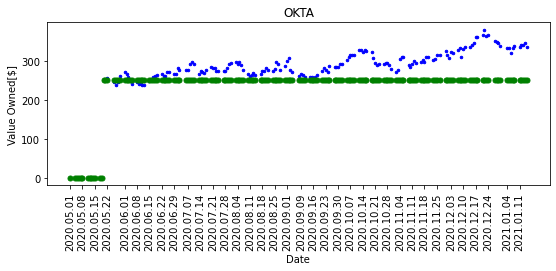

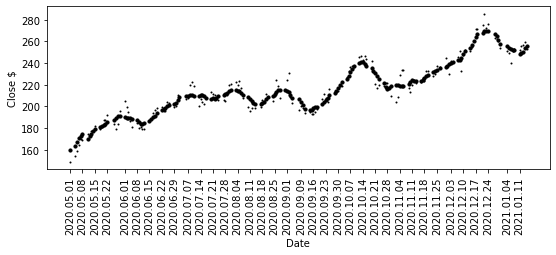

ADBE


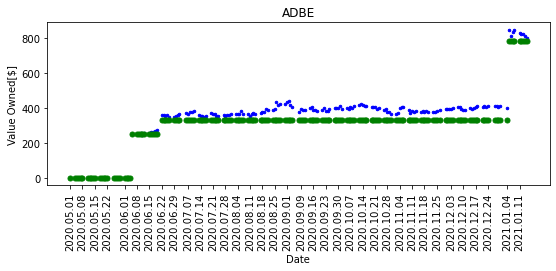

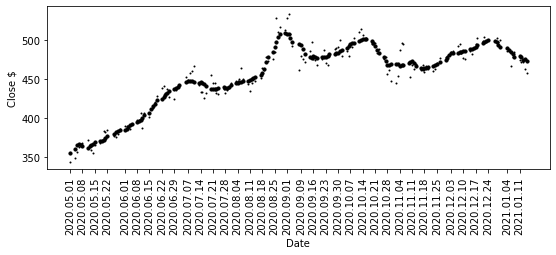

AMZN


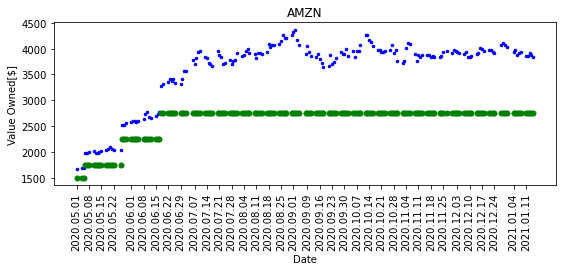

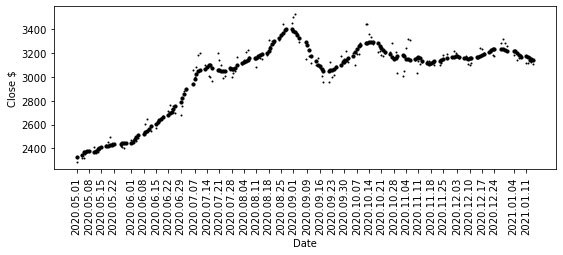

APPN


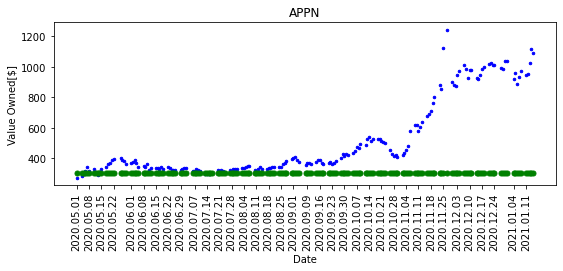

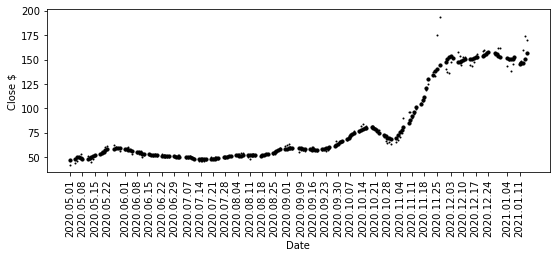

WORK


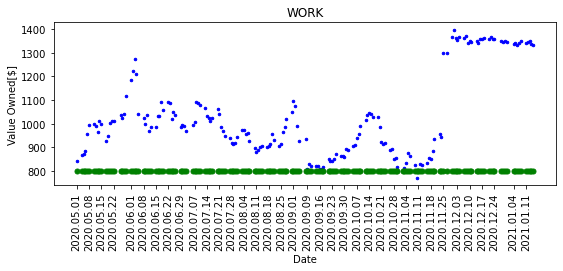

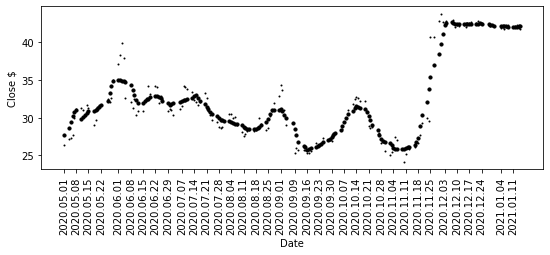

ALB


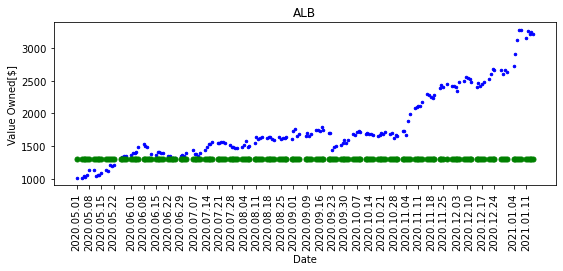

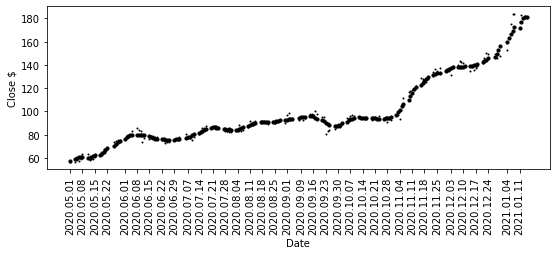

ESTC


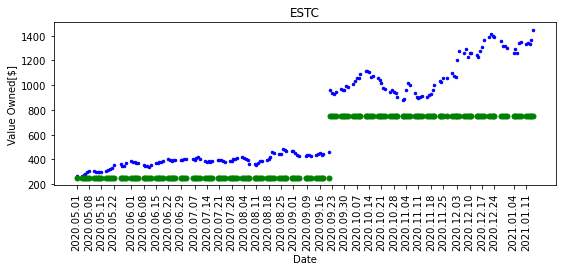

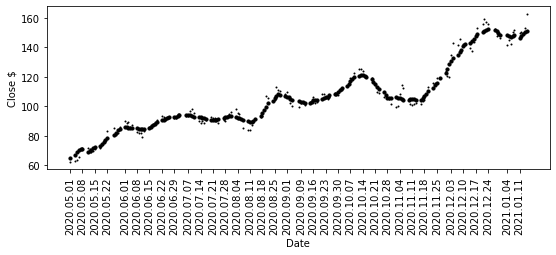

RDFN


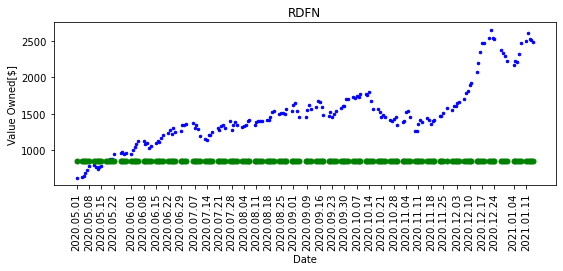

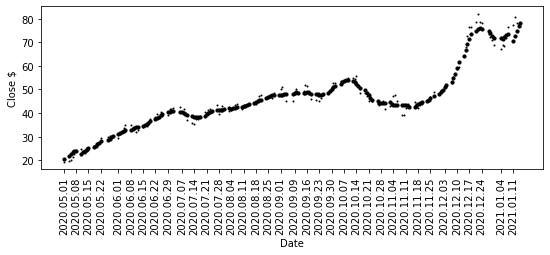

GOOGL


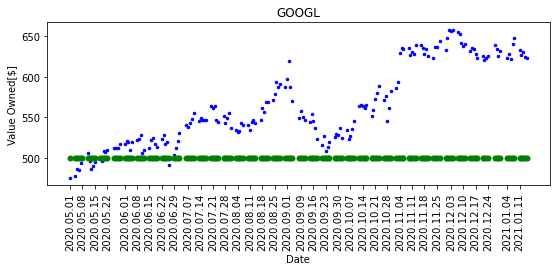

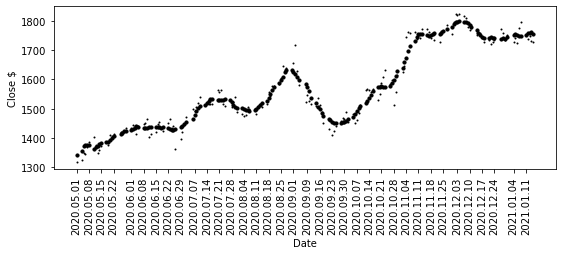

SQM


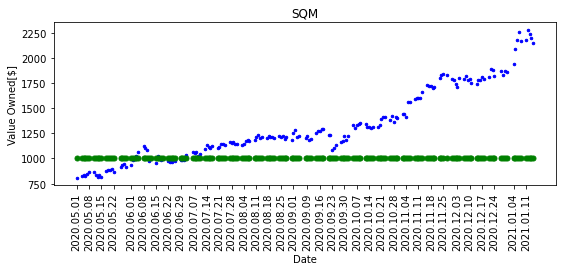

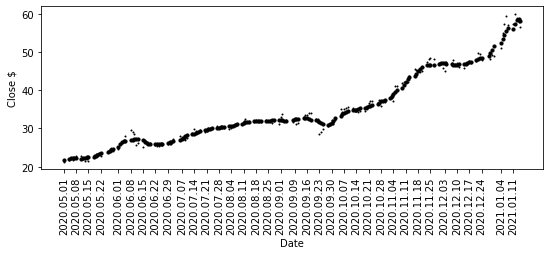

LTHM


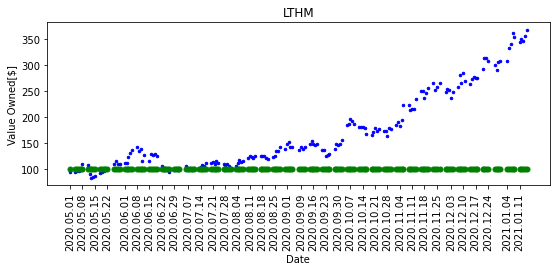

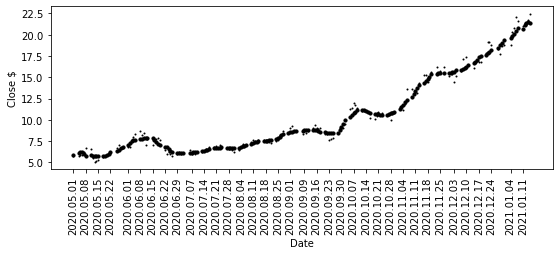

NHI


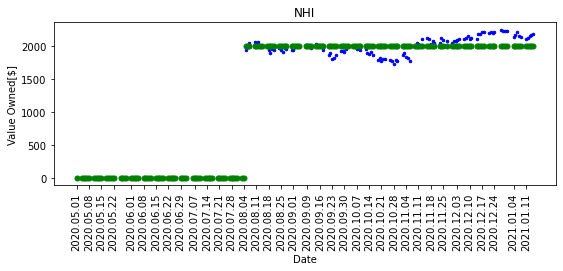

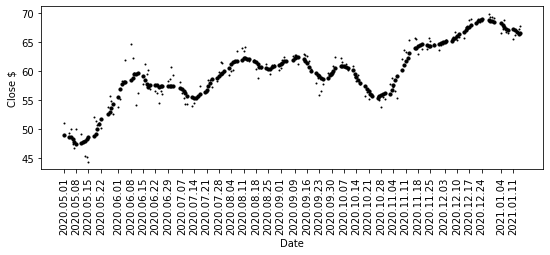

MMM


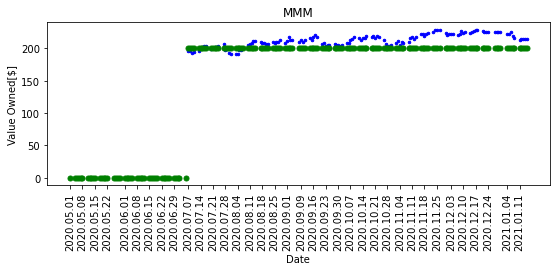

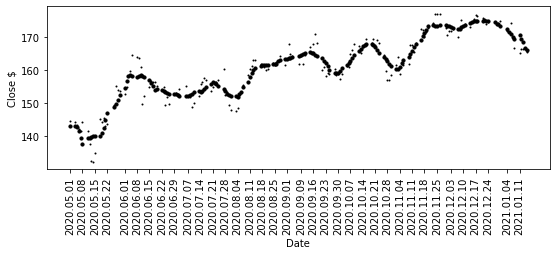

TMUS


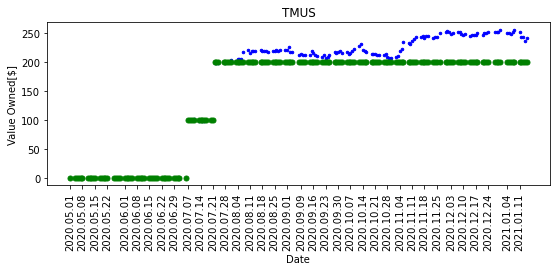

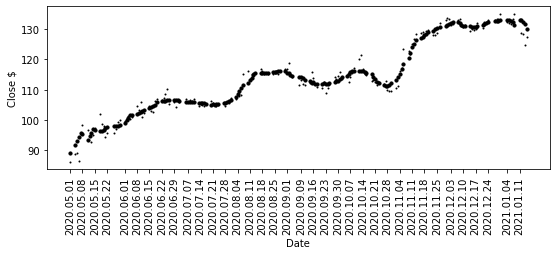

LMND


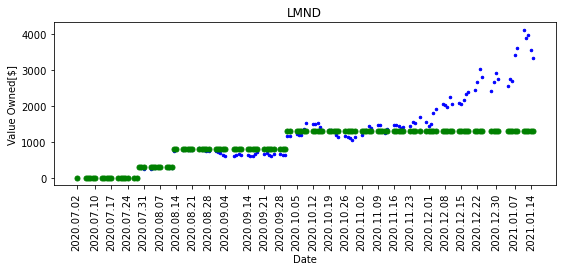

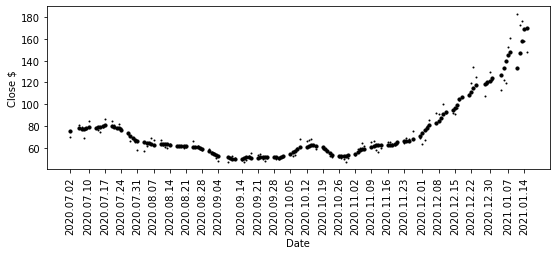

ULTA


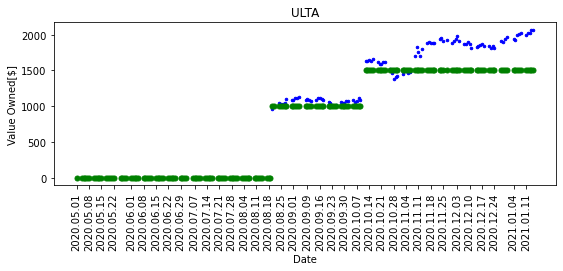

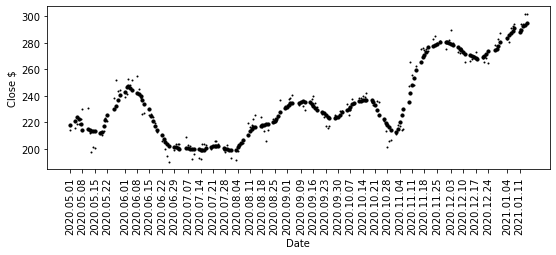

MELI


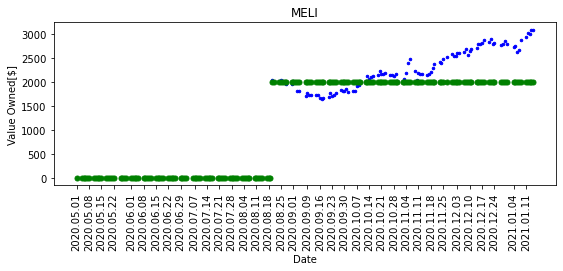

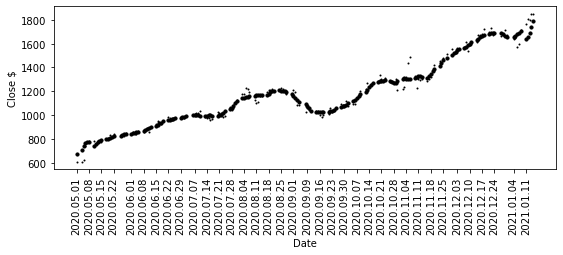

JD


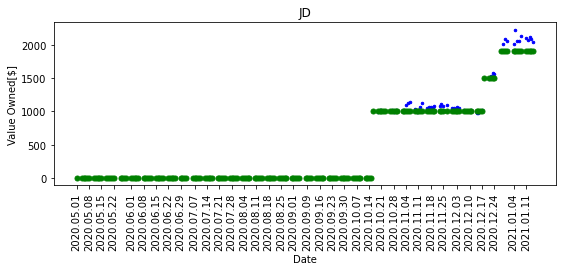

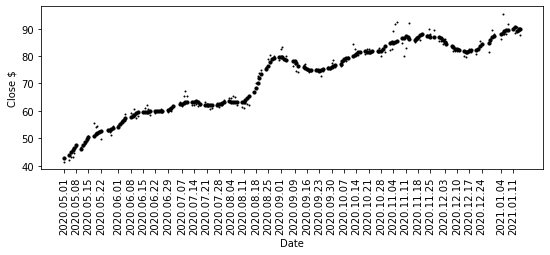

CVS


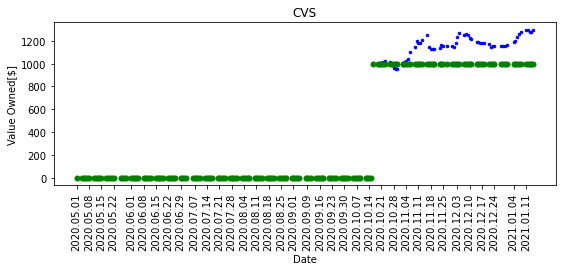

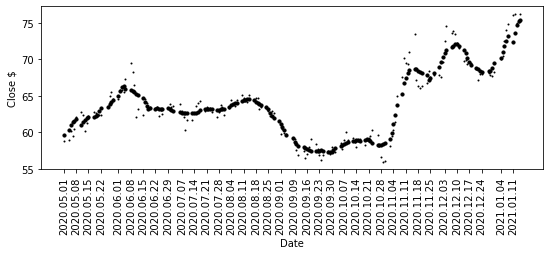

NIO


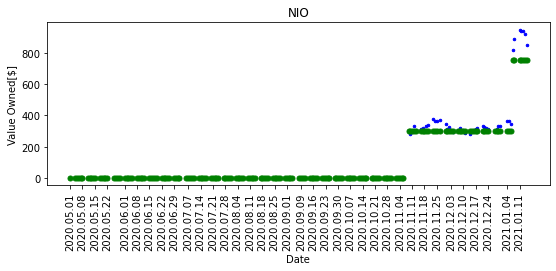

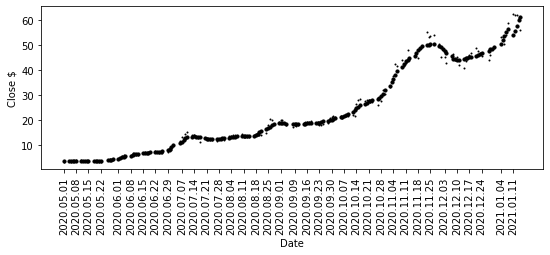

BABA


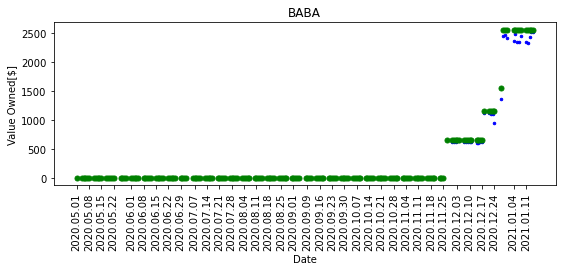

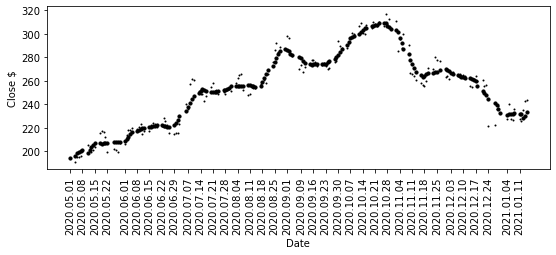

JMIA


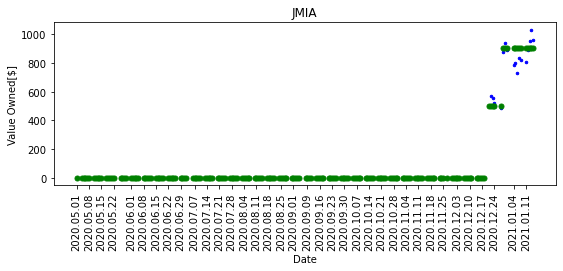

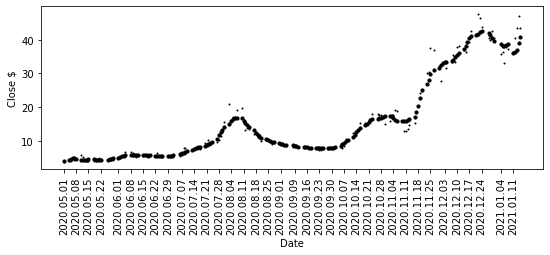

SE


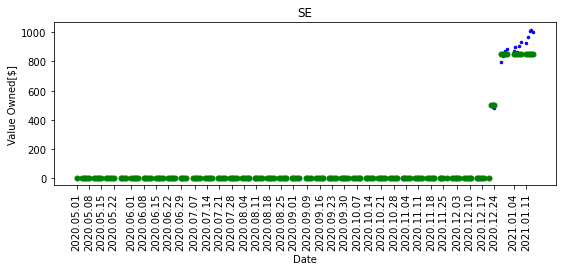

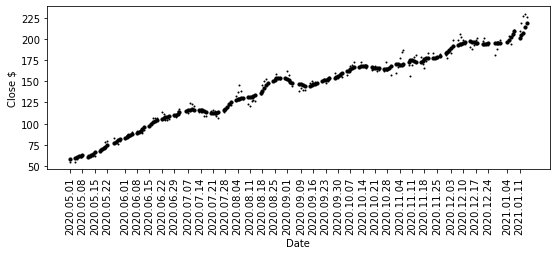

In [10]:
showeach = 5
duration = '180d'
window = 5

for symbol in investments.keys():
    print(symbol)
    df = get_stock_data(symbol,duration)
    df = add_instestments(df,investments,symbol)
    title_string = symbol
    #doubleplot(df, showeach, title_string, window)
    doubleplot_(df, showeach, title_string, window)

In [11]:
outlay = value = 0
labels = []
val_ = []
inv_ = []
per_ = []
gain_ = []
shares = []
close = []
sector = []
area = []
first_invested = []
last_invested = []
investments_made = []
for tik in total:
    outlay = tik['outlay']+ outlay
    value = tik['value']+value
    labels.append(tik['symbol'])
    val_.append(tik['value'])
    inv_.append(tik['outlay'])
    gain_.append(tik['ratio'])
    shares.append(tik['shares'])
    close.append(tik['close'])
    area.append(description[tik['symbol']]['area'])
    sector.append(description[tik['symbol']]['sector'])
    first_invested.append(tik['first_investment'])
    last_invested.append(tik['last_investment'])
    investments_made.append(tik['investments_made'])
    
# special handling for crypto:
tik = eth_
labels.append(tik['symbol'])
val_.append(tik['value'])
inv_.append(tik['invested'])
gain_.append(tik['gain'])
shares.append(tik['shares'])
close.append(tik['close'])
area.append(tik['area'])
sector.append(tik['sector'])
first_invested.append(tik['first_invested'])
last_invested.append(tik['last_invested'])
investments_made.append(tik['investments_made'])

tik = btc_
labels.append(tik['symbol'])
val_.append(tik['value'])
inv_.append(tik['invested'])
gain_.append(tik['gain'])
shares.append(tik['shares'])
close.append(tik['close'])
area.append(tik['area'])
sector.append(tik['sector'])
first_invested.append(tik['first_invested'])
last_invested.append(tik['last_invested'])
investments_made.append(tik['investments_made'])
    
# print((outlay,value,value/outlay))
import pandas as pd

df = pd.DataFrame.from_dict({'symbol':labels,
                             'close':close,
                            'invested':inv_,
                            'value':val_,
                             'gain':gain_,
                             'shares':shares,
                             'sector':sector,
                             'area':area,
                             'first_invested':first_invested,
                             'last_invested':last_invested,
                             'investments_made':investments_made
                            }).sort_values(by=['gain'])

df['percentage_invested'] = df.invested/sum(df.invested)
df['percentage_value'] = 100*df.value/sum(df.value)
df['cp'] = df['invested']/df['shares']

fields = ['symbol','gain','invested','value','shares','close','cp','percentage_value']
df[fields].head(30)



,symbol,gain,invested,value,shares,close,cp,percentage_value
24,btc,0.980009,454.50,445.414124,0.012393,35940.000000,36673.129852,1.100452
20,BABA,0.983921,2550.00,2508.999011,10.305590,243.460007,247.438526,6.198797
5,ADBE,1.024930,780.00,799.445773,1.745210,458.079987,446.937618,1.975131
21,JMIA,1.062274,900.00,956.046170,21.993240,43.470001,40.921665,2.362032
11,MMM,1.069312,200.00,213.862460,1.291830,165.550003,154.819133,0.528374
16,JD,1.076384,1900.00,2045.130447,23.301020,87.769997,81.541495,5.052752
13,NHI,1.088212,2000.00,2176.423723,32.076990,67.849998,62.349990,5.377128
19,NIO,1.133311,750.00,849.983116,15.105440,56.270000,49.650987,2.099990
22,SE,1.179008,850.00,1002.156521,4.433340,226.050003,191.729035,2.475954
10,TMUS,1.208014,200.00,241.602894,1.898200,127.279999,105.362975,0.596910


In [17]:
print('')
fields = ['symbol','gain','invested','value','shares','close','cp','first_invested','last_invested','percentage_value']
df[fields].sort_values(by=['percentage_value']).head(30)

,symbol,gain,invested,value,shares,close,cp,first_invested,last_invested,percentage_value
11,MMM,1.069312,200.00,213.862460,1.291830,165.550003,154.819133,2020.07.07,2020.07.07,0.528374
10,TMUS,1.208014,200.00,241.602894,1.898200,127.279999,105.362975,2020.07.07,2020.07.22,0.596910
0,OKTA,1.347850,250.00,336.962448,1.331920,252.990005,187.698961,2020.05.20,2020.05.20,0.832508
9,LTHM,3.673203,100.00,367.320270,16.339870,22.480000,6.120000,2020.03.11,2020.03.11,0.907511
24,btc,0.980009,454.50,445.414124,0.012393,35940.000000,36673.129852,2020.12.27,2021.01.02,1.100452
7,GOOGL,1.246201,500.00,623.100704,0.360670,1727.619995,1386.308814,2020.02.28,2020.02.28,1.539449
5,ADBE,1.024930,780.00,799.445773,1.745210,458.079987,446.937618,2020.06.05,2021.01.05,1.975131
19,NIO,1.133311,750.00,849.983116,15.105440,56.270000,49.650987,2020.11.09,2021.01.07,2.099990
21,JMIA,1.062274,900.00,956.046170,21.993240,43.470001,40.921665,2020.12.21,2020.12.29,2.362032
22,SE,1.179008,850.00,1002.156521,4.433340,226.050003,191.729035,2020.12.22,2020.12.28,2.475954


In [13]:
print('')
fields = ['symbol','gain','invested','area','sector','first_invested','last_invested','investments_made']
df[fields].sort_values(by=['last_invested']).head(30)

,symbol,gain,invested,area,sector,first_invested,last_invested,investments_made
2,APPN,3.627620,300.00,US,"Tech, Business Processes",2020.02.22,2020.02.22,1
7,GOOGL,1.246201,500.00,US,"Tech, ecclectic",2020.02.28,2020.02.28,1
18,RDFN,2.920533,850.00,US,Real Estate Tech,2020.03.05,2020.03.10,2
3,WORK,1.667480,800.00,US,"Tech, Business Communications",2020.02.22,2020.03.10,2
9,LTHM,3.673203,100.00,US,Li Battery,2020.03.11,2020.03.11,1
8,SQM,2.145516,1000.00,Latin America,"Li Mining, Specialty Chemicals",2020.03.03,2020.03.11,2
4,ALB,2.472090,1300.00,US,"Li Mining, Specialty Chemicals",2020.02.22,2020.04.04,4
0,OKTA,1.347850,250.00,US,"Tech, Security",2020.05.20,2020.05.20,1
1,AMZN,1.395660,2750.00,US,"Virtual Marketplace, Cloud Services",2020.03.10,2020.06.18,7
11,MMM,1.069312,200.00,US,Industrial,2020.07.07,2020.07.07,1


In [14]:
df['dif'] = df['value'] - df['invested']

i = sum(df.invested)
v = sum(df.value)
g = v/i

print('Raw')
print('Total value: \t\t{:8.2f}\nTotal invested: \t{:8.2f}\nTotal gain: \t\t{:8.2f}'.format(
    v,
    i,
    (v-i)
    )
)
print((int(i),int(v),int(g*100)))

tesla_invested = 1250
att_invested = 2416.28
intel_invested = 2000
reinvest_baba = 500
reinvest_jd = 500
reinvest_jmia = 500
reinvest_ethe = 500
reinvest_gbtc = 500
reinvest_se = 500
reinvested = sum([reinvest_baba,reinvest_jd ,reinvest_jmia, reinvest_ethe, reinvest_gbtc, reinvest_se])
cash = 1275.02
i = i + tesla_invested + att_invested + intel_invested - reinvested - cash
g = v/i

#print('\nAdjusted for loss and sales')
#print('Total value: \t\t{:8.2f}\nTotal invested: \t{:8.2f}\nTotal gain: \t\t{:8.2f}'.format(
#    v,
#    i,
#    (v-i)
#    )
#)

# print((int(i),int(v),int(g*100)))

Raw
Total value: 		40475.58
Total invested: 	26801.63
Total gain: 		13673.95
(26801, 40475, 151)


In [15]:
def mklab(s1,s2,s3,s4,s5):
    return '{0}\ninvested:{1}\nvalue:{2}\ngain:{3:6.3f}\nshares:{4:6.3f}'.format(s1,s2,int(s3),s4,s5)

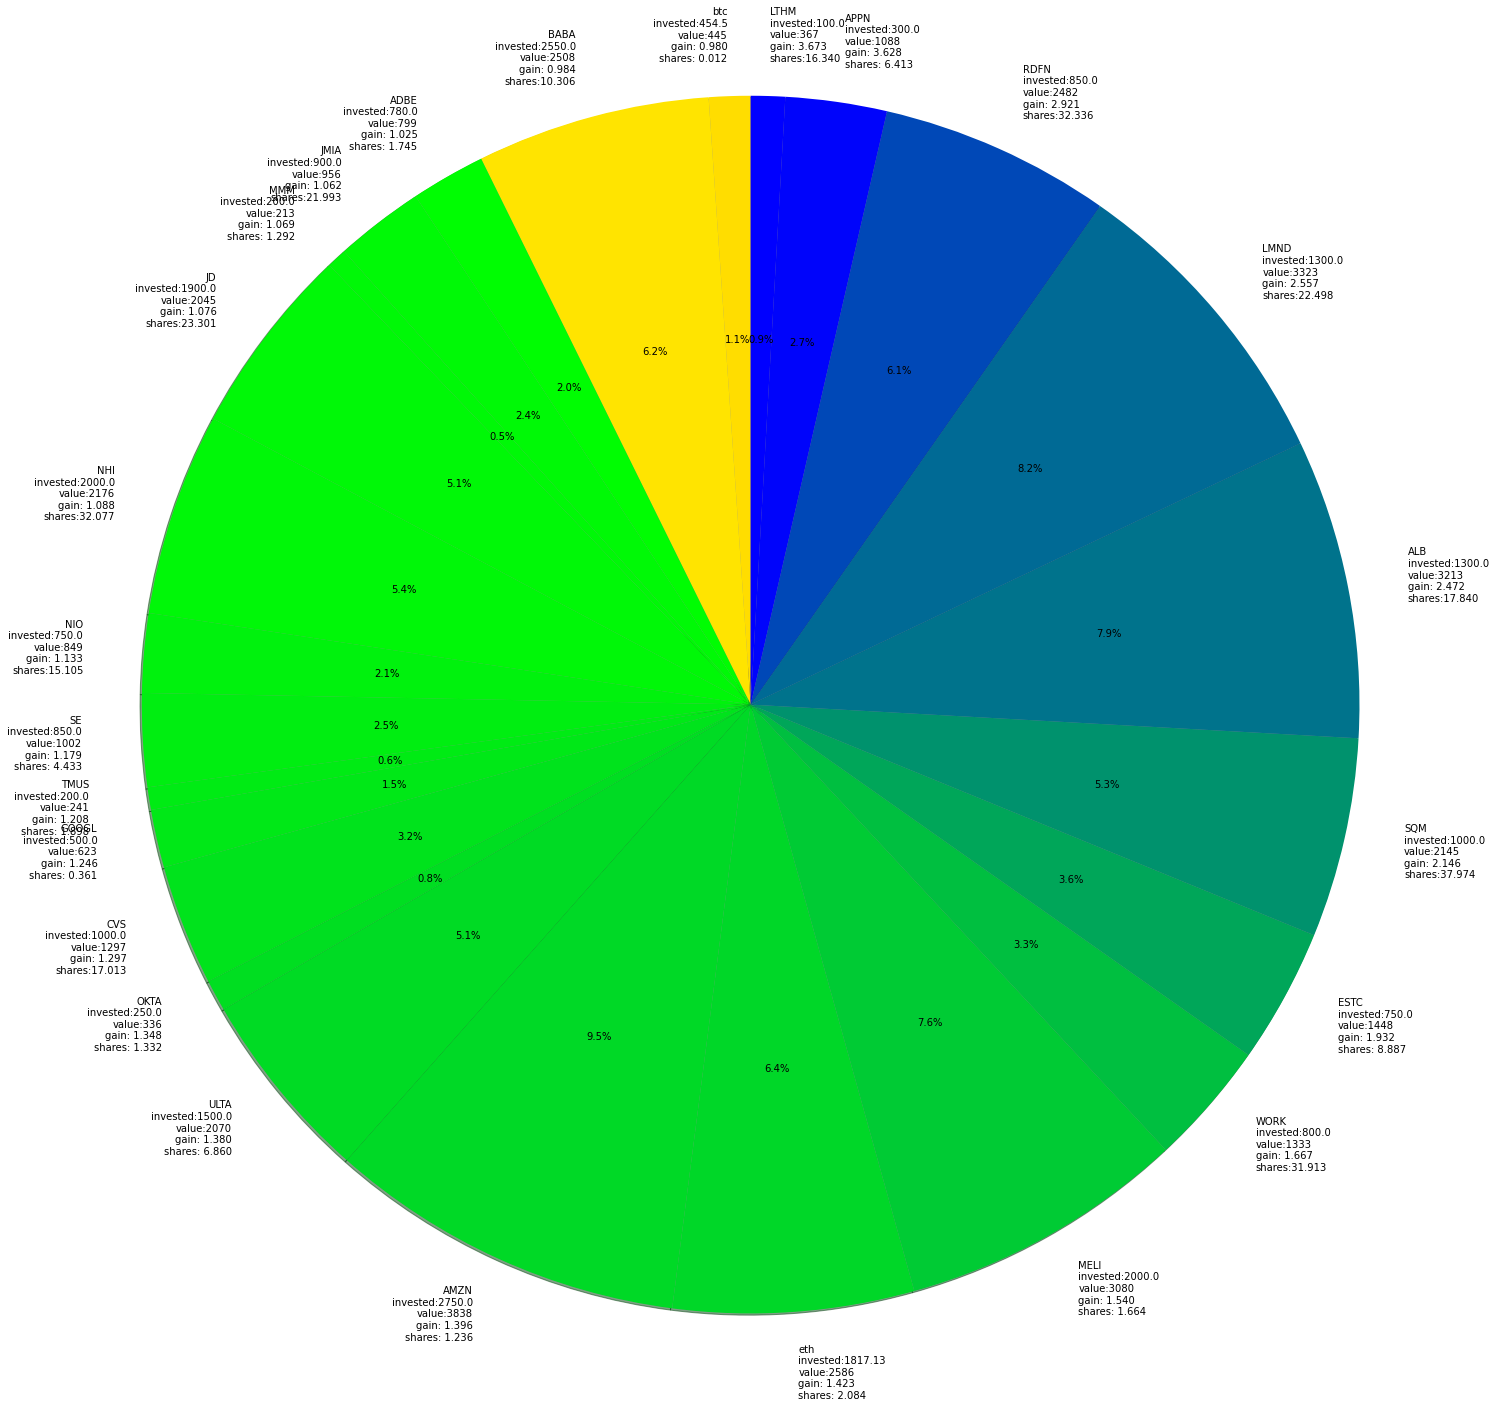

In [16]:
fig1, ax1 = plt.subplots()
df = df.sort_values(by=['gain'])
# rgb_gain(df.gain,0.8,0.95,2)
mn = min( min(df.gain), 0.85)
mx = max( max(df.gain), 3)
label_ = list( map( mklab, df.symbol, df.invested, df.value, df.gain, df.shares) )
ax1.pie(df.value, labels=label_, autopct='%1.1f%%', shadow=True, radius=7, startangle=90, \
        colors=rgb_gain(df.gain,mn,1.0,mx) )
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
fig1, ax1 = plt.subplots()
df = df.sort_values(by=['value'])
# rgb_gain(df.gain,0.8,0.95,2)
# mn = min( min(df.invested), 1)
# mx = max( max(df.invested), 1)
label_ = list( map( mklab, df.symbol, df.invested, df.value, df.gain, df.shares) )
ax1.pie(df.value, labels=label_, autopct='%1.1f%%', shadow=True, radius=4, startangle=90, \
        colors=rgb_gain(df.gain,mn,1.0,mx) )
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
fig1, ax1 = plt.subplots()
df = df.sort_values(by=['value'])
# rgb_gain(df.gain,0.8,0.95,2)
mn = min( min(df.value), 1)
mx = max( max(df.value), 1)
label_ = list( map( mklab, df.symbol, df.invested, df.value, df.gain, df.shares) )
ax1.pie(df.value, labels=label_, autopct='%1.1f%%', shadow=True, radius=4, startangle=90, \
        colors=rgb_gain(df.value,mn,np.median(df.value),mx) )
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
df = df.sort_values(by=['gain']) 
label_ = list( map( mklab, df.symbol, df.invested, df.value, df.gain, df.shares) )
fig1, ax1 = plt.subplots()
ax1.pie(df.invested, labels=label_, autopct='%1.1f%%', shadow=True, radius=4, startangle=90)
#ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [ ]:
showeach = 1
duration = '28d'
window = 3

def ploto(symbol,showeach, duration, window):
    title_string = symbol
    df = get_stock_data(symbol, duration)
    standard_plot(df, showeach, title_string, window)

# for symbol in ['SE','JMIA','LMND','MELI', 'INTC', 'AMD', 'T', 'TMUS', 'RDFN']:
for symbol in ['BTC-USD', 'ETH-USD']:
    ploto(symbol, showeach, duration, window)



In [ ]:
showeach = 7
duration = '112d'
window = 3



In [ ]:
symbol = 'ADBE'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)




In [ ]:
# ATT 0.52 dividend per share.  $30 on Jun-5.
symbol = 'T'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# T Mobile
symbol = 'TMUS'
title_string = symbol


df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# 3M - aristocrat
symbol = 'MMM'
title_string = symbol


df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'FSLY'
title_string = symbol


df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'CRWD'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
showeach = 7
duration = '112d'
window = 7

# Costco and Kroger
symbol = 'COST'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'KR'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'WMT'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'MELI'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'SQ'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# Dominiion energy
symbol = 'D'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
showeach = 7
duration = '56d'
window = 7

# Education online
symbol = 'TWOU'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'CHGG'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

symbol = 'BEDU'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
showeach = 7
duration = '56d'
window = 7

# Zillow 
symbol = 'ZG'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# Redfin 
symbol = 'RDFN'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'ROKU'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# 3D printer.  Proto Labs
symbol = 'PRLB'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# 3D printer.  Strata Sys.  
symbol = 'SSYS'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# 3D printer.  3D Systems
symbol = 'DDD'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
# Fuel cell.  
symbol = 'PLUG'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

# Fuel cell.  Vancouver
symbol = 'BLDP'
title_string = symbol

df = get_stock_data(symbol, duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
symbol = 'ORCL'
title_string = symbol
df = get_stock_data(symbol,duration)
standard_plot(df, showeach, title_string, window)

symbol = 'MU'
title_string = symbol
df = get_stock_data(symbol,duration)
standard_plot(df, showeach, title_string, window)

In [ ]:
df.head(120)

In [ ]:
duration = '5d'
symbol = 'T'
df = yf.Ticker(symbol).history(duration)

In [ ]:
def rgb_steps(steps):
    def rg_steps(steps_rg):
        clrs = []
        for tckr in range(0,steps_rg):
            gclr = 1.00 * (tckr/steps_rg)
            rclr = 1.00 - gclr
            clrs.append((rclr,gclr,0))
        return clrs
    def gb_steps(steps_gb):
        clrs = []
        for tckr in range(0,steps_gb):
            bclr = 1.00 * (tckr/steps_gb)
            gclr = 1.00 - bclr
            clrs.append((0,gclr,bclr))
        return clrs
    
    mdpnt = int(steps/2)
    fnl = steps - mdpnt
    clrs = rg_steps(mdpnt) + gb_steps(fnl)
    return clrs


rgb_steps(22)
